In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Plot the confusion matrix at the end of the tutorial
#from sklearn.metrics import plot_confusion_matrix
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
pd.set_option('mode.chained_assignment', None)

In [3]:
#path = "/content/drive/MyDrive/AXA_Submission/"
df=pd.read_csv('depression_data.csv')
df.head()

,Name,Age,Marital Status,Education Level,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Chronic Medical Conditions
0,Christine Barker,31,Married,Bachelor's Degree,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No,Yes,Yes
1,Jacqueline Lewis,55,Married,High School,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No,No,Yes
2,Shannon Church,78,Widowed,Master's Degree,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No,Yes,No
3,Charles Jordan,58,Divorced,Master's Degree,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No,No,No
4,Michael Rich,18,Single,High School,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No,Yes,Yes


In [4]:
df.drop(columns=["Name"], inplace = True)

In [5]:
def new_y(y):
  le = LabelEncoder()
  return le.fit_transform(y)

In [6]:
def new_X(X):
  transformer_social = ColumnTransformer(transformers=[
    ('s1', OneHotEncoder(), ['Marital Status', 'Employment Status']),
    ('s2', OrdinalEncoder(categories=[['High School','Associate Degree',"Bachelor's Degree", "Master's Degree",'PhD']]),['Education Level'])
    ],remainder='drop')
  pipe_social = Pipeline([
    ('num_s', transformer_social),
    ('scaler_s', MinMaxScaler()),
    ('pca_s', PCA(n_components=1))])
  transformer_health = ColumnTransformer(transformers=[
    ('h1', OneHotEncoder(), ['Smoking Status', 'Sleep Patterns']),
    ('h2', OrdinalEncoder(categories=[['Active', 'Moderate', 'Sedentary'],
                                     ['Low','Moderate', 'High'],
                                     ['Healthy', 'Moderate', 'Unhealthy']]),['Physical Activity Level', 'Alcohol Consumption', 'Dietary Habits'])
    ],remainder='drop')
  pipe_health = Pipeline([
    ('num_h', transformer_health),
    ('scaler_h', MinMaxScaler()),
    ('pca_h', PCA(n_components=1))])

  transformer_history = ColumnTransformer(transformers=[
    ('hh1', OneHotEncoder(), ['History of Substance Abuse','Family History of Depression', 'Chronic Medical Conditions'])]
    ,remainder='drop')

  pipe_history = Pipeline([
    ('num_h', transformer_history),
    ('pca_h', PCA(n_components=1))])

  transformer_num = ColumnTransformer(transformers=[
    ('t1', MinMaxScaler(), ["Age", "Number of Children", "Income"])]
    ,remainder='drop')

  num_col = transformer_num.fit_transform(X)
  Health_History = pipe_history.fit_transform(X)
  Health_Status = pipe_health.fit_transform(X)
  Social_Status = pipe_social.fit_transform(X)

  return np.hstack((num_col, Social_Status,Health_Status, Health_History))

In [7]:
X = df.drop(["History of Mental Illness"], axis=1)
y = df["History of Mental Illness"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [9]:
y_train.value_counts()

,count
History of Mental Illness,
No,230461
Yes,100553


In [10]:
X_train = new_X(X_train)
X_test = new_X(X_test)
y_train = new_y(y_train)
y_test  = new_y(y_test)

In [11]:
sm = SMOTE(random_state=46)
X_sam, y_sam = sm.fit_resample(X_train, y_train)

X_train_oversampled = X_sam
y_train_oversampled = y_sam

In [12]:
np.unique(y_train_oversampled, return_counts=True)

(array([0, 1]), array([230461, 230461]))

In [13]:
clf_lr = LogisticRegression(random_state=46)
clf_rf = RandomForestClassifier(random_state=46)
clf_svm = svm.SVC(random_state=46)
clf_xgb = XGBClassifier(random_state=46)

In [14]:
param_range = [2, 3, 4]
param_depth = [4,5,6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [100,150,200]
learning_rates = [0.1,0.01,0.2]

lr_param_grid = [{'penalty': ['l1', 'l2'],
                   'C': param_range_fl,
                   'solver': ['liblinear']}]

svm_param_grid = [{'kernel': ['linear', 'rbf'],
                    'C': param_range}]

rf_param_grid = [{'min_samples_leaf': param_range,
                   'max_depth': param_depth,
                   'min_samples_split': param_range[1:]}]

xgb_param_grid = [{'learning_rate': learning_rates,
                    'max_depth': param_depth,
                    'min_child_weight': param_range[:2],
                    'subsample': param_range_fl,
                    'n_estimators': n_estimators,
                    'objective': ['binary:logistic']}]

In [15]:
lr_grid_search = GridSearchCV(estimator=clf_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=3)
svm_grid_search = GridSearchCV(estimator=clf_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=3)
rf_grid_search = GridSearchCV(estimator=clf_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=3)
xgb_grid_search = GridSearchCV(estimator=clf_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=3)

XGB Test Accuracy: 0.438105710902192
XGB Best Params: {'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.69      0.34      0.46     57482
           1       0.31      0.66      0.42     25272

    accuracy                           0.44     82754
   macro avg       0.50      0.50      0.44     82754
weighted avg       0.58      0.44      0.45     82754



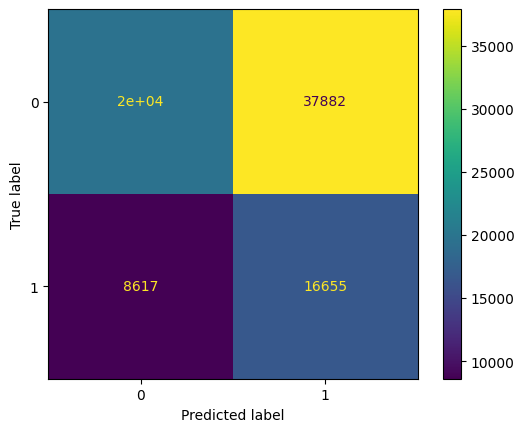

In [17]:
xgb_grid_search.fit(X_train_oversampled,y_train_oversampled)
best_xgb = xgb_grid_search.best_estimator_

print('XGB Test Accuracy: {}'.format( xgb_grid_search.score(X_test,y_test)))
print('XGB Best Params: {}'.format( xgb_grid_search.best_params_))



y_pred = best_xgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [ ]:
svm_grid_search.fit(X_train_oversampled,y_train_oversampled)
best_svm = svm_grid_search.best_estimator_

print('SVM Test Accuracy: {}'.format( svm_grid_search.score(X_test,y_test)))
print('SVM Best Params: {}'.format( svm_grid_search.best_params_))



y_pred = best_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=cm).plot();